**Installing Necessary Libraries**

In [14]:
!pip install mat4py
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from mat4py import loadmat
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.svm import SVC
from sklearn.utils.validation import column_or_1d
from sklearn.metrics import accuracy_score ,  confusion_matrix , ConfusionMatrixDisplay , roc_curve , roc_auc_score , RocCurveDisplay,auc
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
data = loadmat('/content/fisheriris_matlab.mat')
df_x = pd.DataFrame(data['meas'])
# for column in df_x:
#   df_x[column] = df_x[column]/np.amax(df_x[column])
df_y = pd.DataFrame(data['species'])

In [16]:
data = df_x.to_numpy()
labels = df_y.to_numpy()
# print(np.unique(labels))
le  = LabelEncoder()
le.fit(labels)
labels  = le.transform(labels)
classes=le.classes_
# print(labels)
# labels = column_or_1d(labels, warn=True)
print(data.shape,labels.shape)

(150, 4) (150,)


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [17]:
train_x , test_x , train_y , test_y = train_test_split(data,labels,train_size = 0.7,shuffle=True,random_state=0)

In [18]:
from sklearn.preprocessing import label_binarize
#binarize the y_values
def roc_curve_self(y_test,pred_prob):
  y_test_binarized=label_binarize(test_y,classes=np.unique(test_y))

  # roc curve for classes
  fpr = {}
  tpr = {}
  thresh ={}
  roc_auc = dict()

  n_class = classes.shape[0]

  for i in range(n_class):    
      fpr[i], tpr[i], thresh[i] = roc_curve(y_test_binarized[:,i], pred_prob[:,i])
      roc_auc[i] = auc(fpr[i], tpr[i])
      
      # plotting    
      plt.plot(fpr[i], tpr[i], linestyle='--', 
              label='%s vs Rest (AUC=%0.2f)'%(classes[i],roc_auc[i]))

  plt.plot([0,1],[0,1],'b--')
  plt.xlim([0,1])
  plt.ylim([0,1.05])
  plt.title('Multiclass ROC curve')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive rate')
  plt.legend(loc='lower right')
  plt.show()

In [36]:
# parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
# clf = GridSearchCV(classifier_rbf, parameters)
# clf.fit(train_x,train_y)
# print(clf.cv_results_)
def valid_curve(estimator):
  param_range = np.logspace(-6, -1, 5)
  train_score, test_score = validation_curve(estimator, train_x, train_y,
                                        param_name = "gamma",
                                        param_range = param_range ,
                                          cv = 5, scoring = "accuracy")

  train_scores_mean = np.mean(train_score, axis=1)
  train_scores_std = np.std(train_score, axis=1)
  test_scores_mean = np.mean(test_score, axis=1)
  test_scores_std = np.std(test_score, axis=1)

  plt.title("Validation Curve with SVM")
  plt.xlabel(r"$\gamma$")
  plt.ylabel("Score")
  plt.ylim(0.0, 1.1)
  lw = 2
  plt.semilogx(
      param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
  )
  # plt.fill_between(
  #     param_range,
  #     train_scores_mean - train_scores_std,
  #     train_scores_mean + train_scores_std,
  #     alpha=0.2,
  #     color="darkorange",
  #     lw=lw,
  # )
  plt.semilogx(
      param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
  )
  # plt.fill_between(
  #     param_range,
  #     test_scores_mean - test_scores_std,
  #     test_scores_mean + test_scores_std,
  #     alpha=0.2,
  #     color="navy",
  #     lw=lw,
  # )
  plt.legend(loc="best")
  plt.show()


In [37]:
np.unique(test_y)

array([0, 1, 2])

# **RBF Kernel**

In [40]:
classifier_rbf=SVC(kernel="rbf", probability=True)
classifier_rbf.fit(train_x,train_y)

SVC(probability=True)

In [41]:

y_pred_rbf = classifier_rbf.predict(test_x)
pred_rbf = classifier_rbf.predict_proba(test_x)
accuracy_score(test_y, y_pred_rbf)

0.9777777777777777

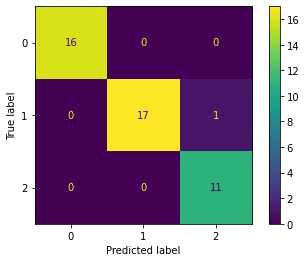

In [42]:
cm_rbf = confusion_matrix(test_y, y_pred_rbf)
disp_rbf = ConfusionMatrixDisplay(cm_rbf)
disp_rbf.plot()
plt.show()

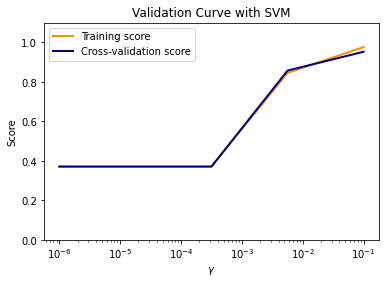

In [43]:
valid_curve(classifier_rbf)

AUROC Score:  0.9968457266932212


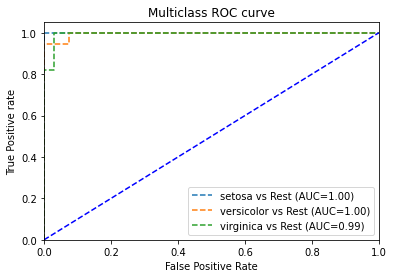

In [44]:
print('AUROC Score: ',roc_auc_score(test_y,pred_rbf,multi_class="ovr"))
roc_curve_self(test_y,pred_rbf)

# **Sigmoid Kernel**

In [45]:
classifier_sigmoid=SVC(kernel="sigmoid", probability=True)
classifier_sigmoid.fit(train_x,train_y)

SVC(kernel='sigmoid', probability=True)

In [46]:
y_pred_sigmoid = classifier_sigmoid.predict(test_x)
pred_sigmoid = classifier_sigmoid.predict_proba(test_x)
accuracy_score(test_y, y_pred_sigmoid)

0.24444444444444444

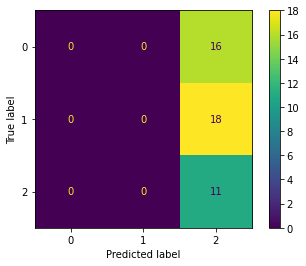

In [47]:
cm_sigmoid = confusion_matrix(test_y, y_pred_sigmoid)
disp_sigmoid = ConfusionMatrixDisplay(cm_sigmoid)
disp_sigmoid.plot()
plt.show()

AUROC Score:  0.7616496899984241


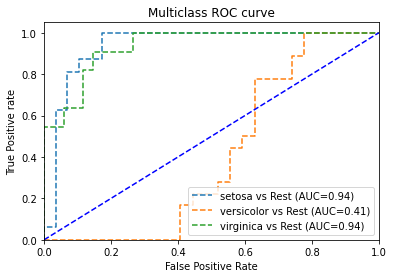

In [48]:
print('AUROC Score: ',roc_auc_score(test_y,pred_sigmoid,multi_class="ovr"))
roc_curve_self(test_y,pred_sigmoid)

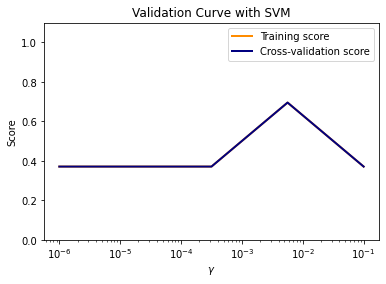

In [49]:
valid_curve(classifier_sigmoid)

# **Polynomial Kernel**

In [56]:
classifier_polynomial=SVC(kernel="poly", probability=True)
classifier_polynomial.fit(train_x,train_y)

SVC(kernel='poly', probability=True)

In [57]:
y_pred_poly = classifier_polynomial.predict(test_x)
pred_poly = classifier_polynomial.predict_proba(test_x)
accuracy_score(test_y, y_pred_poly)

0.9777777777777777

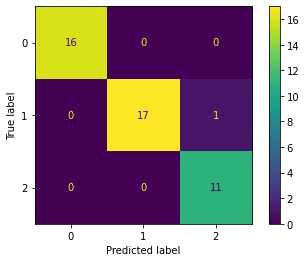

In [58]:
cm_poly = confusion_matrix(test_y, y_pred_poly)
disp_poly = ConfusionMatrixDisplay(cm_poly)
disp_poly.plot()
plt.show()

AUROC Score:  0.9952685900398318


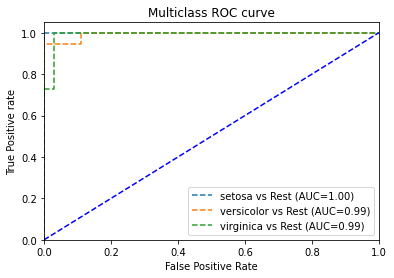

In [59]:
print('AUROC Score: ',roc_auc_score(test_y,pred_poly,multi_class="ovr"))
roc_curve_self(test_y,pred_poly)

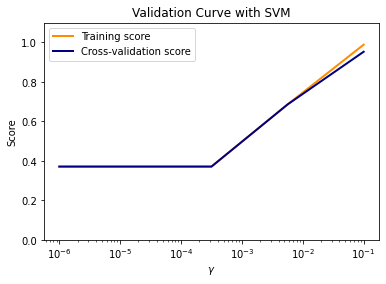

In [60]:
valid_curve(classifier_polynomial)

# **Linear Kernel**

In [61]:
classifier_linear=SVC(kernel="linear", probability=True)
classifier_linear.fit(train_x,train_y)

SVC(kernel='linear', probability=True)

In [62]:
y_pred_linear = classifier_linear.predict(test_x)
pred_linear = classifier_linear.predict_proba(test_x)
accuracy_score(test_y, y_pred_linear)

0.9777777777777777

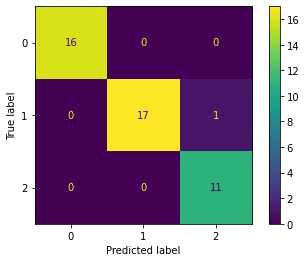

In [63]:
cm_linear = confusion_matrix(test_y, y_pred_linear)
disp_linear = ConfusionMatrixDisplay(cm_linear)
disp_linear.plot()
plt.show()

AUROC Score:  0.9968457266932212


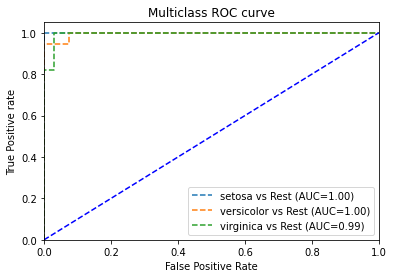

In [64]:
print('AUROC Score: ',roc_auc_score(test_y,pred_linear,multi_class="ovr"))
roc_curve_self(test_y,pred_linear)

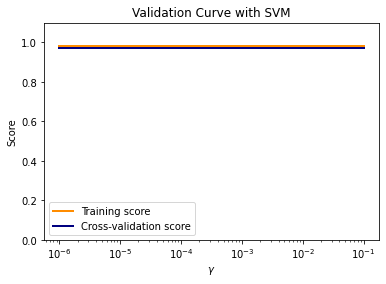

In [65]:
valid_curve(classifier_linear)